In [1]:
# General imports
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits

# Grizli
import grizli
from grizli.model import GrismFLT
import pysynphot as S

os.chdir("/Users/keith/astr/research_astr/summer-roman-project/4) FOV0_sims/fits")
root = "GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits" # Change filename with this variable
direct_file = "ready_direct_{0}".format(root)
seg_file = "seg_{0}".format(root)

/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [2]:
# Identify objects of interest
tbl = Table.read("cat_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits.detect.cat", format="ascii.ecsv")

# Ensure you are using rotated coordinates
coords = (abs(tbl["x_flt"] - 4040) < 5) & (abs(tbl["y_flt"] - 3770) < 10)
index = np.where(coords)

tbl[index].pprint_all()

 id        x_flt             y_flt           mag_approx        segment_flux     mag  hlss_id      distance        z     MODIMAGE          SED           A_IMAGE B_IMAGE THETA_IMAGE
---- ----------------- ----------------- ------------------ ------------------ ----- ------- ----------------- -------- -------- ---------------------- ------- ------- -----------
7132 4036.515246784876 3765.933941026709 20.337751291830788 291.13191613554955 20.41    2678 2.060589700997127 1.464803        0 SED:rest:gal.2678.fits  1.7864  0.7212      340.84


In [3]:
# Instantiate the GrismFLT object
pad = 100
roman_sim = GrismFLT(direct_file=direct_file, seg_file=seg_file, pad=pad)



Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation seg_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits[0]
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


In [4]:
# Read object id and mag
id, mag = tbl['id'][index].value[0], tbl['mag'][index].value[0]

# Create Bandpass object
df = Table.read("/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/wfirst_wfi_f158_001_syn.fits", format='fits')
bp = S.ArrayBandpass(df["WAVELENGTH"], df["THROUGHPUT"])

# Read in SED
SED_dir = "/Users/keith/astr/research_astr/FOV0/FOV0_SEDs"
specific_sed = tbl["SED"][index].value[0]
print("SED Template:", specific_sed)
file = fits.open(os.path.join(SED_dir, specific_sed))
SED_data = file[1].data
file.close()

# Extract wavelength and flux
rest_wave = np.asarray([tuple[0] for tuple in SED_data])
flux = np.asarray([tuple[1] for tuple in SED_data])
z = tbl['z'][index]

# redshifted_wave = rest_wave * (z+1) # Redshift Wave

spec = S.ArraySpectrum(wave=rest_wave, flux=flux, waveunits='angstrom', fluxunits='flam').redshift(z).renorm(mag, 'abmag', bp)
spec.convert("flam")

SED Template: SED:rest:gal.2678.fits


In [5]:
# Compute Spectrum
print("Computing model order; id:{0} mag:{1}".format(id, mag))

roman_sim.compute_model_orders(id=id, mag=mag, compute_size=False, 
                               size=77, in_place=True, spectrum_1d=[spec.wave, spec.flux], is_cgs=True)
model_orders = np.rot90(roman_sim.model[pad:-pad, pad:-pad])

Computing model order; id:7132 mag:20.41


In [6]:
# load in wang et al
file = fits.open("/Users/keith/astr/research_astr/FOV0/slitless/GRS_FOV0_roll0_dx0_dy0_SCA1_slitless_final.fits")
data = file[1].data
file.close()

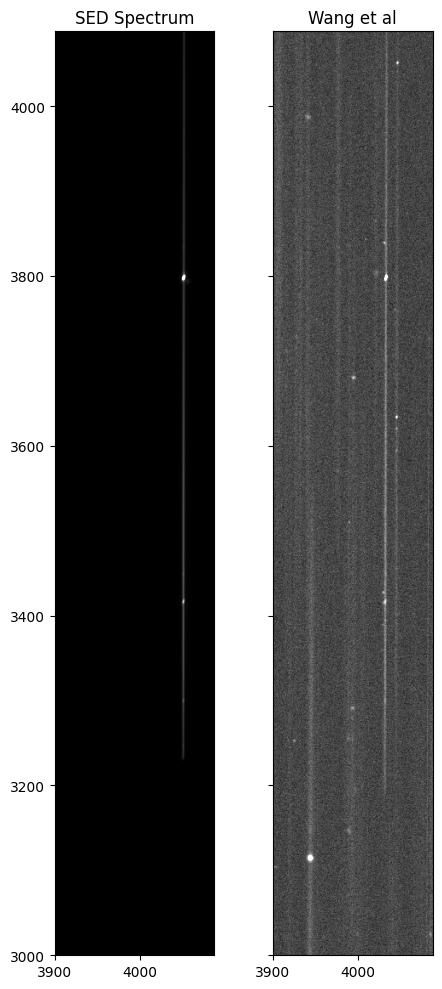

In [7]:
# Display comparison image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,10))

ax1.imshow(model_orders, origin="lower", cmap='grey', vmax=np.max(data)/200)
ax1.set_xlim(3900, 4088)
ax1.set_ylim(3000,4088)
ax1.set_title("SED Spectrum")

ax2.imshow(data, origin="lower", cmap='grey', vmax=np.max(data)/100)
ax2.set_xlim(3900, 4088)
ax2.set_ylim(3000,4088)
ax2.set_title("Wang et al")
ax2.set_yticklabels([])

fig.tight_layout()